# Altri algoritmi di ottimizzazione

In questo notebook utilizzeremo la stessa architettura di rete neurale creata in [questo notebook](https://github.com/ProfAI/dl00/blob/master/5%20-%20Addestramento%20e%20algoritmi%20di%20ottimizzazione/Stochastic%2C%20Mini%20batch%20e%20Full%20batch%20Gradient%20Descent.ipynb) per il [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) al fine di confrontare diversi algoritmi di ottimizzazione. 
<br>
<br>
Cominciamo importando i moduli che ci serviranno

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History 

from keras import optimizers

from time import time

from scripts.random import set_seed # da utilizzare per poter riprodurre i miei risultati

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preparazione dei dati
Carichiamo il dataset Fashion MNIST utilizzando Keras e preprocessiamo i dati.

In [2]:
from keras.datasets import fashion_mnist

# Caricamento del dataset

labels = ["T-shirt/top","Pantalone","Pullover","Vestito","Cappotto","Sandalo","Maglietta","Sneaker","Borsa","Stivaletto"]

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Encoding delle immagini

X_train = X_train.reshape(X_train.shape[0],28*28)
X_test = X_test.reshape(X_test.shape[0],28*28)

# Normalizzazione

X_train = X_train/255
X_test = X_test/255

# Encoding del target

num_classes=10

y_train_dummy = to_categorical(y_train, num_classes)
y_test_dummy = to_categorical(y_test, num_classes)

Adesso ogni immagine è codificata in un vettore contenente il valore dei pixel normalizzati disposti su di un'unica riga.
<br>
Il target è codificato all'interno di 10 variabili dummy, una per ogni classe, in cui la variabile alla posizione della classe di appartenenza vale 1 (True), mentre le altre valgono 0 (False).

## Funzioni utili
Durante il notebook avremo bisogno di ri-definire e ri-addestrare la stessa rete diverse volte, cambiando soltanto la funzione di ottimizzazione. 
Definiamo alcune funzioni utili che ci serviranno per non dover riscrivere il codice.
<br>
<br>
Questa funzione definisce l'architettura del modello impostando un seed comune per l'inizializzazione casuale dei pesi e ritorna il modello.

In [3]:
def build_model():

    set_seed(0) # per poter riprodurre i miei risultati

    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

Questa funzione disegna il grafico della funzione di costo ad ogni epoca dell'algoritmo di ottimizzazione.

In [4]:
def plot_loss(optimizer, loss):
    plt.figure(figsize=(14,10))
    plt.title(optimizer)
    plt.xlabel("Epoca")
    plt.ylabel("Log-Loss")
    plt.plot(loss)

Questa funziona avvia l'addestramento della rete e cronomoetra il tempo di esecuzione, infine mostra le metriche (accuracy e loss) e il grafico della funzione di costo.

In [5]:
def train_and_time(model, optimizer):
        
    history = History()

    start_at = time()
    model.fit(X_train, y_train_dummy, epochs=100, batch_size=512, callbacks=[history], verbose=0)
    train_time = time() - start_at
    
    metrics = model.evaluate(X_train, y_train_dummy, verbose=0)

    print("Tempo di addestramento: %d minuti e %d secondi" % (train_time/60, train_time%60))
    print("Accuracy = %.4f - Loss = %.4f" % (metrics[1], metrics[0]))

    plot_loss(optimizer, history.history['loss'])

    return model

## Utilizzare il Momentum
Il momemtum è un concetto proveniente dalla fisica e permette di far convergere il Gradient Descent più velocemente nella direzione corretta, accumulando gli update degli step precendenti.
<br><br>
$$
\begin{align*}
&V_t = \gamma V_{t-1} + \eta \nabla J(W) \\
&W = W - V_t
\end{align*}
$$
<br><br>
Cominciamo costruendo il modello utilizzando la funzione <span style="font-family: Monaco">build_model</span> che abbiamo definito prima.

In [6]:
model = build_model()

Adesso, per poter impostare il momentum, dobbiamo creare un nuovo ottimizzatore di tipo Stochastic Gradient Descent e passare al suo interno nel parametro <span style="font-family: Monaco">momentum</span> il valore della costante gamma, che va ad 0 ad 1, con un valore consigliato di 0.9.<br>
Dopodichè possiamo passare l'ottimizzatore così creato all'interno del parametro <span style="font-family: Monaco">optimizer</span> del metodo <span style="font-family: Monaco">compile</span>.

In [7]:
sgd = optimizers.SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Adesso possiamo avviare la fase di addestramento, utilizzando la funzione <span style="font-family: Monaco">train_and_time</span> definita il precendenza.

Tempo di addestramento: 2 minuti e 57 secondi
Accuracy = 0.9868 - Loss = 0.0407


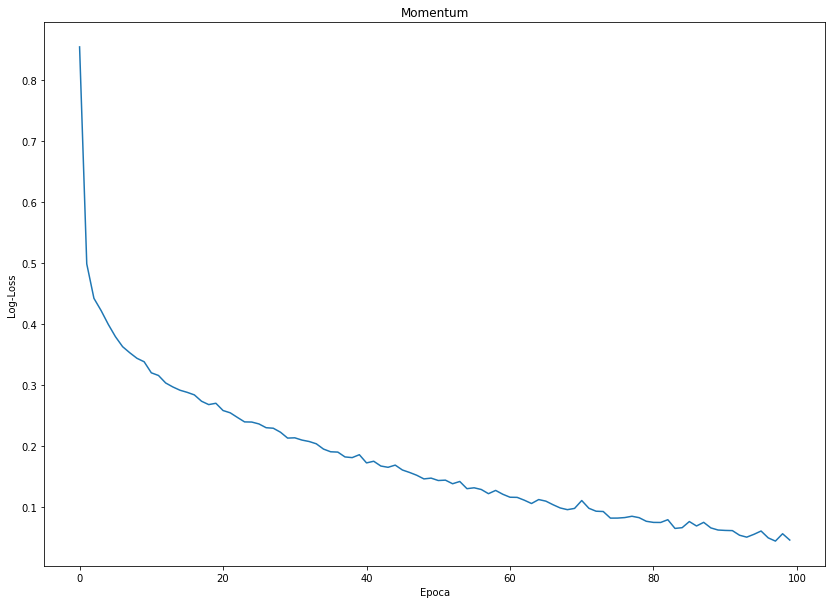

In [8]:
model = train_and_time(model, "Momentum")

## Nesterov Momentum

Il Nesterov Momentum è un espansione del momentum che tenta di prevedere il prossimo step del gradient descent eseguendo una stima con l'update dell'epoca precedente.

$$
\begin{align*}
&V_t = \gamma V_{t-1} + \eta \nabla J(W-\gamma V_{t-1}) \\
&W = W - V_t
\end{align*}
$$

Per utilizzare il Nesterov Momentum dobbiamo solamente passare il paramentro <span style="font-family: Monaco">nesterov=True</span> quando definiamo l'ottimizzatore.

In [27]:
model = build_model() # ricreiamo il modello

sgd = optimizers.SGD(momentum=0.9, nesterov=True) # impostiamo il nesterov momentum
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Tempo di addestramento: 3 minuti e 15 secondi
Accuracy = 0.9889 - Loss = 0.0359


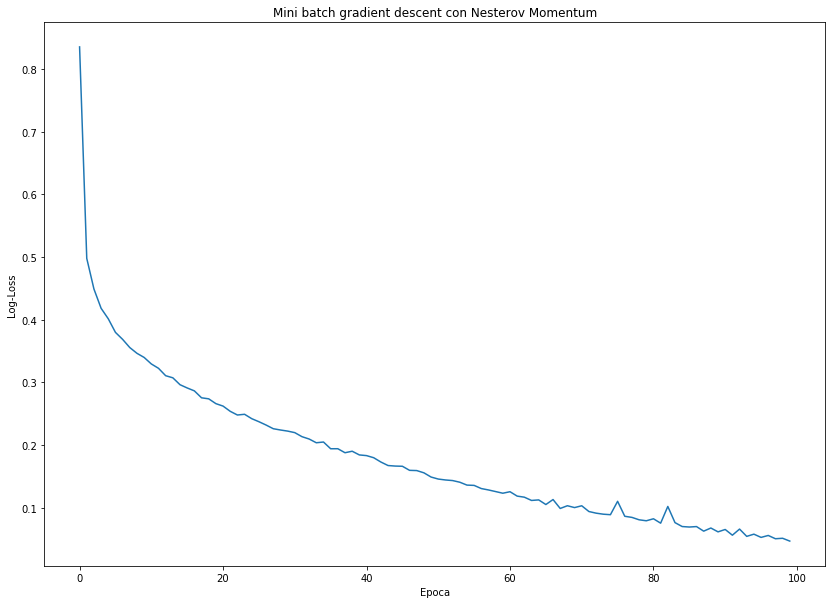

In [28]:
model = train_and_time(model, "Nesterov Momentum")

## AdaGrad

L'AdaGrad è un algoritmo di ottimizzazione che permette di ottenere un valore del *learning rate* dinamico, ciò che varia ad ogni iterazione e che si adatta alle features assumendo valore maggiore per le features più rare.

$$
\begin{align*}
&g_t = \nabla J(\theta) \\
&\theta = \theta - \frac{\eta}{\sqrt{G_t + \epsilon}}\cdot g_t
\end{align*}
$$

Dove $G_t$ è una matrice diagonale che contiene che contiene la somma dei quadrati di ogni derivata parizale delle epoche precedenti, mentre $\epsilon$ è una costante molto piccola ($\approx 1^{-8}$) utilizzata per evitare la divisione per zero.
<br>
L'AdaGrad elimina anche il problema di dover selezionare il *learning rate* manualmente, infatti un valore standard di 0.01 va bene nella maggior parte dei casi.

In [12]:
model = build_model()

adagrad = optimizers.Adagrad()
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])

Tempo di addestramento: 3 minuti e 1 secondi
Accuracy = 0.9905 - Loss = 0.0309


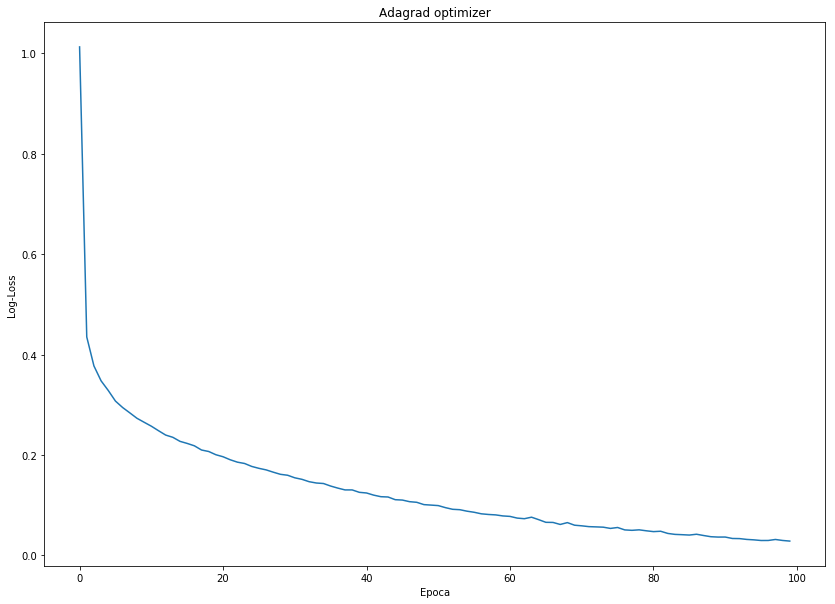

In [13]:
model = train_and_time(model, "Adagrad optimizer")

In [14]:
model.evaluate(X_test, y_test_dummy)

10000/10000 [==============================] - 0s 38us/step


[0.5168809212565422, 0.8942]

Lo svantaggio principale dell'AdaGrad è che è troppo aggressivo, andando a ridurre eccessivamente il *learning rate* con l'avanzare delle epoche.

## RMSprop
L'algoritmo di ottimizzazione RMSprop è una soluzione al problema dell'Adagrad proposta da Geoff Hinton, che piuttosto che accumulare i gradienti di tutte le epoche precedenti, raccoglie solo quelli di un ultimo quadro temporale utilizzando una media mobile esponenziale.

$$
\begin{align*}
&g_t = \nabla J(W) \\
&E[g^2] = \gamma E[g^2]_{t-1} + (1-\gamma)g^2_t \\
&W = W - \frac{\eta}{\sqrt{E[g^2] + \epsilon}}\cdot g_t
\end{align*}
$$

Anche qui il valore consigliato per $\gamma$ è 0.9, mentre per il *learning rate* è 0.001.

In [15]:
model = build_model()

rmsprop = optimizers.RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

Tempo di addestramento: 3 minuti e 44 secondi
Accuracy = 0.9771 - Loss = 0.0903


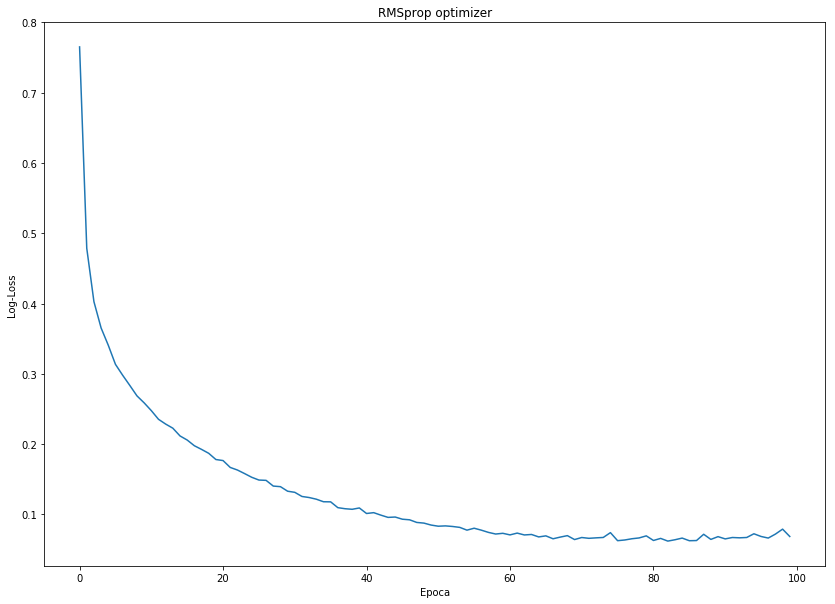

In [16]:
model = train_and_time(model, "RMSprop optimizer")

In [17]:
model.evaluate(X_test, y_test_dummy)

10000/10000 [==============================] - 0s 42us/step


[0.9188727992572356, 0.8932]

## Adadelta
L'Adadelta è un'espansione dell'Adagrad che utilizza un approccio del tutto simile al RMSprop per affrontare il problema della riduzione del *learning rate*.

Per approfondire la parte matematica dell'Adadelta, dai uno sguardo al paper originale su Arxiv: [Adadelta: an Adapive Learning Rate Method](https://arxiv.org/abs/1212.5701)

In [18]:
model = build_model()

adadelta = optimizers.Adadelta()
model.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

Tempo di addestramento: 3 minuti e 37 secondi
Accuracy = 0.9780 - Loss = 0.0607


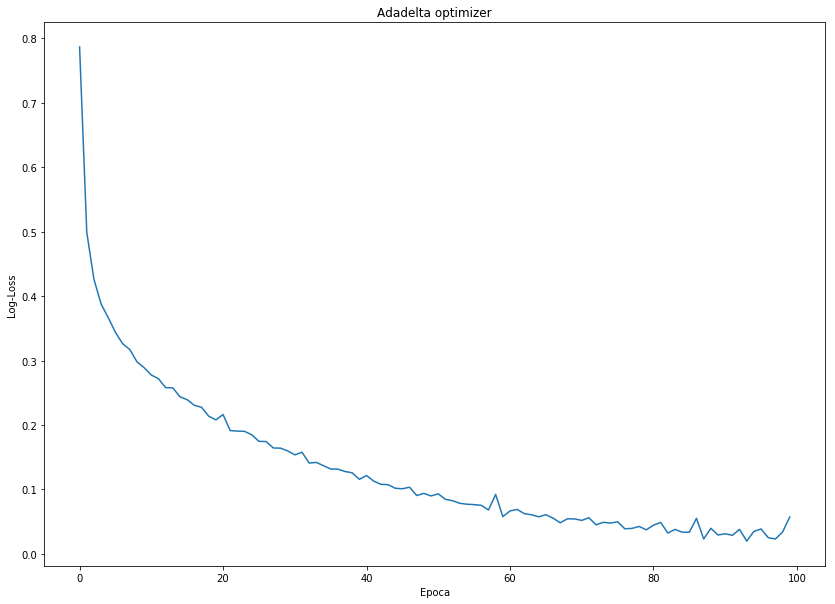

In [19]:
model = train_and_time(model, "Adadelta optimizer")

In [20]:
model.evaluate(X_test, y_test_dummy)

10000/10000 [==============================] - 0s 45us/step


[0.6713147650517524, 0.8921]

## Adam
L'Adam è un algoritmo di ottimizzazione basato sul RMSprop che fa anche uso del Momentum

$$
\begin{align*}
&g_t = \nabla J(W) \\
&m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t \\
&v_t = \beta_2 v_{t-1} + (1-\beta_2)g^2_t \\
&\hat{m}_t = \frac{m_t}{1-\beta^t_1} \\
&\hat{v}_t = \frac{v_t}{1-\beta^t_2} \\
&W = W - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}}\cdot \hat{m}_t
\end{align*}
$$

Il valore consigliato per $\beta_1$ è 0.9 e per $\beta_2$ 0.999.
Nella pratica è stato dimostrato che Adam è l'algoritmo di ottimizzazione più performante nella maggior parte dei casi, per approfondire dai uno sguardo al paper originale su Arxiv [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980).

In [21]:
model = build_model()

adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Tempo di addestramento: 3 minuti e 38 secondi
Accuracy = 0.9964 - Loss = 0.0104


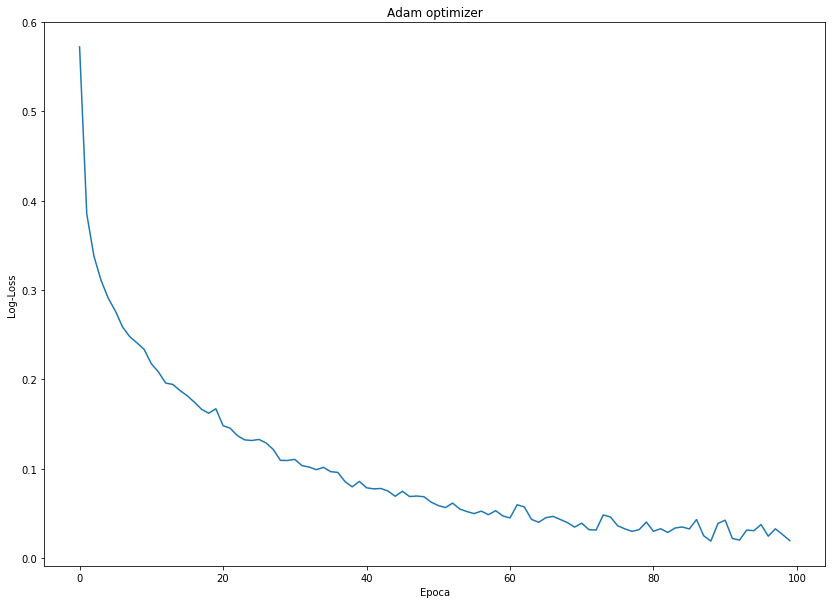

In [22]:
model = train_and_time(model, "Adam optimizer")

In [23]:
model.evaluate(X_test, y_test_dummy)

10000/10000 [==============================] - 1s 57us/step


[0.730893776518479, 0.8985]

# Adamax
L'algortimo di ottimizzazione Adamax è un'espansione dell'Adam che lo rende più robusto nel caso di array sparsi.

$$
\begin{align*}
&\hat{u}_t = \max{(\beta_2 v_{t-1},|g_t|)} \\
&\theta = \theta - \frac{\eta}{\hat{u}_t}\cdot \hat{m}_t
\end{align*}
$$

Per approfondire fai sempre riferimento al paper [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980).


In [24]:
model = build_model()

adamax = optimizers.Adamax()
model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['accuracy'])

Tempo di addestramento: 3 minuti e 26 secondi
Accuracy = 0.9904 - Loss = 0.0243


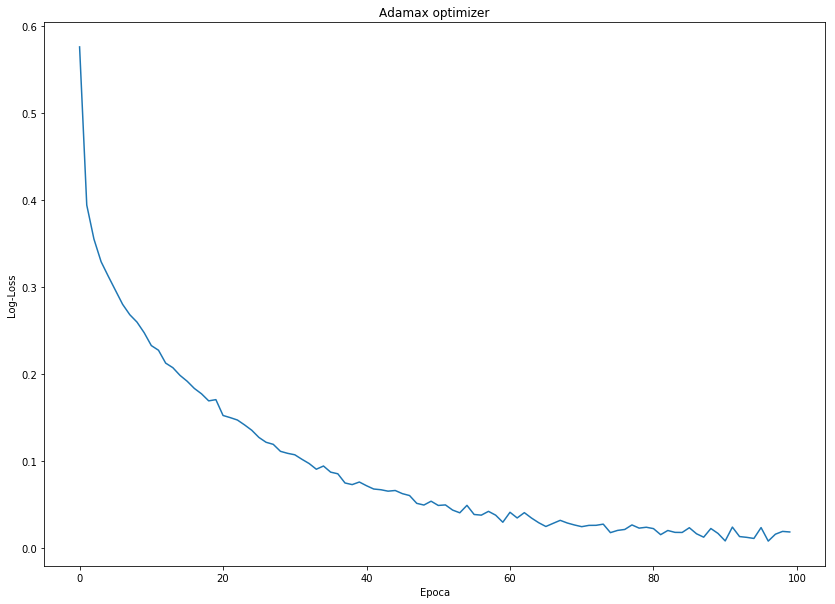

In [25]:
model = train_and_time(model, "Adamax optimizer")

In [26]:
model.evaluate(X_test, y_test_dummy)

10000/10000 [==============================] - 0s 35us/step


[0.7265704807467759, 0.8929]

# Nadam
L'algoritmo di ottimizzazione Nadam è un espansione dell'Adam che fa utilizzo del Nesterov Momentum.
$$
\begin{align*}
&\theta = \theta - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}}\cdot (\beta_1 \hat{m}_t + \frac{(1-\beta_1)g_t}{1-\beta_1^t})
\end{align*}
$$

Per approfondire la parte matematica dai uno sguardo a questo paper: [Incorporating Nesterov Momentum into Adam](http://cs229.stanford.edu/proj2015/054_report.pdf)


In [ ]:
model = build_model()

nadam = optimizers.Nadam()
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

In [ ]:
model = train_and_time(model, "Nadam optimizer")

## Abbiamo creato una super rete neurale ?

Sulla [repository del Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) possiamo vedere dei benchmark, cioè i risultati (in questo caso l'accuracy), di modelli creati da diversi riceratori. 
<img src="res/fmnist-benchmarks.png" />
A quanto pare l'accuracy del nostro banalissimo modello, ottenuta con diversi algoritmi di ottimizzazione, è superiore a quella di modelli creati da ricercatori esperti con modelli ben più complessi. E' davvero così ! **NO**. Il modello va valutato su osservazioni a lui sconosciute, cioè osservazioni che non gli sono state mostrate durante la fase di addestramento.
Facciamolo, utilizzando il test set per valutare l'ultimo modello addestrato.

In [ ]:
test_metrics = model.evaluate(X_test, y_test_dummy)
print("Log loss su test set: %.4f - Accuracy sul test set: %.4f" % (test_metrics[0], test_metrics[1]))

I risultati sul set di test sono decisamente peggiori, specialmente la log loss, questo vuol dire che il modello è molto più incerto nel classificare gli esempi del test set.
<br>
Questa grossa differenza tra set di addestramento e set di test è dovuta ad un problema conosciuto come overfitting, che sarà argomento della prossima sezione.